
# Elección de la mejor predición


VAmos a trabajar con las sigueinte  __Series de tiempos __ que nos da ventas mensuales de coles en Quebec desde 1960 hasta 1968. Este dataset puede ser bajado de aquí: 

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

El objetivo de este notebook es explorar diferentes modelos para predecir 
las ventas futuras. 

Seguiremos los siguientes pasos:

1. Preparación de datos.
2. Separar los datos en entrenamiento, test y validación.
3. Construir los diferentes modelos.
4. Ajustar los modelos o a los datos de entrenamiento.
5. Evaluar cada modelo en el conjunto de valildación y elegir el mejor.
6. Evaluar el modelo en el conjunto de test.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

### Preparación de datos

In [2]:
cars_df = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Limpiamos última fila

In [5]:
cars_df = cars_df.iloc[:-1]

In [3]:
cars_df.head()

,Month,Monthly car sales in Quebec 1960-1968
0,1960-01,6550.0
1,1960-02,8728.0
2,1960-03,12026.0
3,1960-04,14395.0
4,1960-05,14587.0


Cambiamos el formato de las fechas

In [6]:
cars_df["dt"] = cars_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

Renombramos la columna `Monthly car sales in Quebec 1960-1968` por  `sales` y eliminamos la columna `Month`.

In [7]:
cars_df = cars_df\
    .rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)\
    .drop("Month", axis=1)
cars_df.tail()

,sales,dt
103,16722.0,1968-08-01
104,14385.0,1968-09-01
105,21342.0,1968-10-01
106,17180.0,1968-11-01
107,14577.0,1968-12-01


Dibujamos nuestra serie de tiempos:

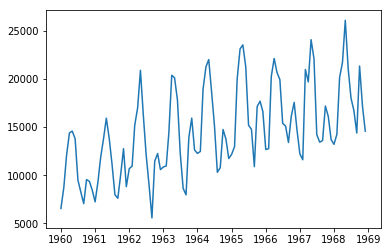

In [8]:
plt.plot(cars_df["dt"], cars_df["sales"])

Verificamos que tenemos datos de todos los meses:

In [9]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Separar los datos en entrenamiento, test y validación.


* Mucho cuidado que cuando trabajamos series de tiempos no podemos hacer el split aleatoriamente ya que se trata de predecir datos a futuro. Por tanto tenemos respetar que el conjunto de validación y test son usando datos posteriores al conjunto de entrenamiento.

In [17]:
train = cars_df.sort_values("dt")[:round(cars_df.shape[0]*0.6)+1]
train.shape[0]

66

In [19]:
validation = cars_df.sort_values("dt")[round(cars_df.shape[0]*0.6)+1:round(cars_df.shape[0]*0.8)+1]
validation.shape[0]

21

In [20]:
test = cars_df.sort_values("dt")[round(cars_df.shape[0]*0.8)+1:]
test.shape[0]

21

In [23]:
train.iloc[65]

sales                  21247
dt       1965-06-01 00:00:00
Name: 65, dtype: object

In [25]:
validation.iloc[0]

sales                  15189
dt       1965-07-01 00:00:00
Name: 66, dtype: object

In [26]:
validation.iloc[20]

sales                  20985
dt       1967-03-01 00:00:00
Name: 86, dtype: object

In [27]:
test.iloc[0]

sales                  19692
dt       1967-04-01 00:00:00
Name: 87, dtype: object

In [33]:
train = cars_df[cars_df["dt"].dt.year < 1967]
validation = cars_df[cars_df["dt"].dt.year == 1967]
test = cars_df[cars_df["dt"].dt.year > 1967]
train.shape[0], validation.shape[0], test.shape[0]

(84, 12, 12)

## Modelo 1: media de las anteriores ventas


Un simple modelo es predecir a futuro el valor de la media de los datos anteriores.

In [44]:
pred = validation
pred["y_hat"] = train["sales"].mean()
pred.head()

/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,sales,dt,y_hat
84,12225.0,1967-01-01,13792.357143
85,11608.0,1967-02-01,13792.357143
86,20985.0,1967-03-01,13792.357143
87,19692.0,1967-04-01,13792.357143
88,24081.0,1967-05-01,13792.357143


Dibujamos su performance

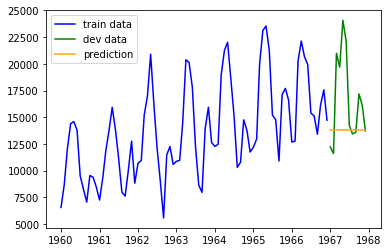

In [81]:
def plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat):
    plt.plot(X_train, y_train, c="blue", label='train data')
    plt.plot(X_dev, y_dev, c="green", label='dev data')
    plt.plot(X_dev, y_dev_hat, c="orange", label='prediction')
    plt.legend()
    plt.show()
    
plot_predicition(train["dt"], train["sales"], validation["dt"], validation["sales"], pred["y_hat"])

Vemos que la predición no es buena, pero nos sirve para tener un __baseline__, un punto de comienzo para ir mejorando con otros modelos.

Para la evaluación del performance del modelo usaremos el error cuadrático medio, MSE, y su raiz, RSME que nos servirán para elegir el mejor modelo.

In [46]:
from sklearn.metrics import mean_squared_error

X_train = train["dt"]
y_train = train["sales"]
X_dev = validation["dt"]
y_dev = validation["sales"]
y_dev_hat = pred["y_hat"]
print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  23847172.57993197
RMSE:  4883.356691859808


## Modelo 2: media del año anterior

Vamos a tomar la media de los últimos doce meses

In [64]:
y_dev_hat = [train[train["dt"].dt.year == (1967-1)].mean()]*12

This time it looks better.

In [66]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

##  Modelo 3: valor del mes anterior


A menudo, para predecir el valor del siguiente mes, usamos el valor del anterior mes. Para ello vamos a añadir una nueva feature que nos da el valor del mes anterior usando el método en python llamado `shift`. esto es llamado __lag__.

In [67]:
Xy_with_lags = cars_df.copy()
Xy_with_lags["Anterior"] = Xy_with_lags["sales"].shift(1)

In [71]:
Xy_with_lags.head()

,sales,dt,Anterior
0,6550.0,1960-01-01,NaN
1,8728.0,1960-02-01,6550.0
2,12026.0,1960-03-01,8728.0
3,14395.0,1960-04-01,12026.0
4,14587.0,1960-05-01,14395.0


In [72]:
X_dev.head()

84   1967-01-01
85   1967-02-01
86   1967-03-01
87   1967-04-01
88   1967-05-01
Name: dt, dtype: datetime64[ns]

In [76]:
Xy_with_lags["dt"]

0     1960-01-01
1     1960-02-01
2     1960-03-01
3     1960-04-01
4     1960-05-01
5     1960-06-01
6     1960-07-01
7     1960-08-01
8     1960-09-01
9     1960-10-01
10    1960-11-01
11    1960-12-01
12    1961-01-01
13    1961-02-01
14    1961-03-01
15    1961-04-01
16    1961-05-01
17    1961-06-01
18    1961-07-01
19    1961-08-01
20    1961-09-01
21    1961-10-01
22    1961-11-01
23    1961-12-01
24    1962-01-01
25    1962-02-01
26    1962-03-01
27    1962-04-01
28    1962-05-01
29    1962-06-01
         ...    
78    1966-07-01
79    1966-08-01
80    1966-09-01
81    1966-10-01
82    1966-11-01
83    1966-12-01
84    1967-01-01
85    1967-02-01
86    1967-03-01
87    1967-04-01
88    1967-05-01
89    1967-06-01
90    1967-07-01
91    1967-08-01
92    1967-09-01
93    1967-10-01
94    1967-11-01
95    1967-12-01
96    1968-01-01
97    1968-02-01
98    1968-03-01
99    1968-04-01
100   1968-05-01
101   1968-06-01
102   1968-07-01
103   1968-08-01
104   1968-09-01
105   1968-10-

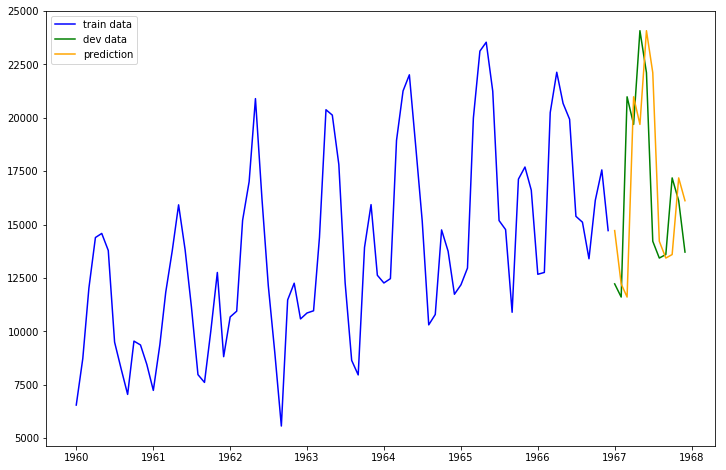

<Figure size 432x288 with 0 Axes>

In [85]:
figure = plt.subplots(1,1,figsize=(12,8))

train = Xy_with_lags[Xy_with_lags["dt"].dt.year < 1967]
validation = Xy_with_lags[Xy_with_lags["dt"].dt.year == 1967]
test = Xy_with_lags[Xy_with_lags["dt"].dt.year > 1967]

X_train = train["dt"]
y_train = train["sales"]
X_dev = validation["dt"]
y_dev = validation["sales"]
y_dev_hat = validation["Anterior"]

plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)
plt.tight_layout()

In [86]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

##  Modelo 4: modelo de Autoregresion (AR)


Es claro que los datos de Diciembre de un año y el anterior están correlacionados. Vamos a calcular si es cierto haciendo la función de correlación entre un periodo y el de un año anterior (usaremos lags).

In [149]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy = cars_df.copy()
Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['sales']

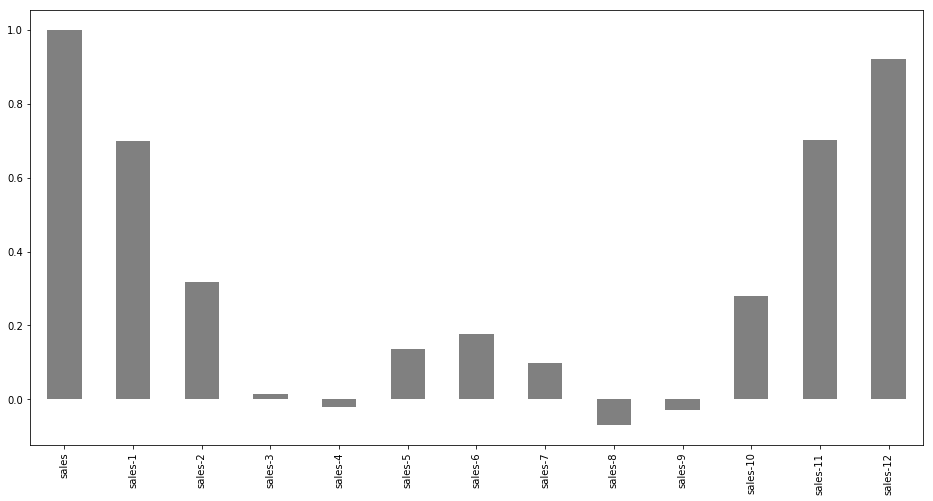

In [93]:
autocorrelations.plot(kind='bar',color='gray', figsize=(16,8))

In [120]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:]
Xy_with_lags.head()

,sales,dt,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
24,10677.0,1962-01-01,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0,9374.0,7237.0
25,10947.0,1962-02-01,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0,9374.0
26,15200.0,1962-03-01,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0
27,17010.0,1962-04-01,15200.0,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0
28,20900.0,1962-05-01,17010.0,15200.0,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0


Elegimos las columnas que son más correladas con sales.

In [146]:
train = Xy_with_lags[Xy_with_lags["dt"].dt.year < 1967]
validation = Xy_with_lags[Xy_with_lags["dt"].dt.year == 1967]
test = Xy_with_lags[Xy_with_lags["dt"].dt.year > 1967]

X_train = train["dt"]
y_train = train["sales"]
X_dev = validation["dt"]
y_dev = validation["sales"]

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Xy_with_lags[["sales-1", "sales-11", "sales-12"]], Xy_with_lags["sales"])

y_dev_hat = reg.predict(validation[["sales-1", "sales-11", "sales-12"]])

Eliminamos los Nas de los lags y construimos un modelo lineal

In [122]:
#WRITE YOUR CODE

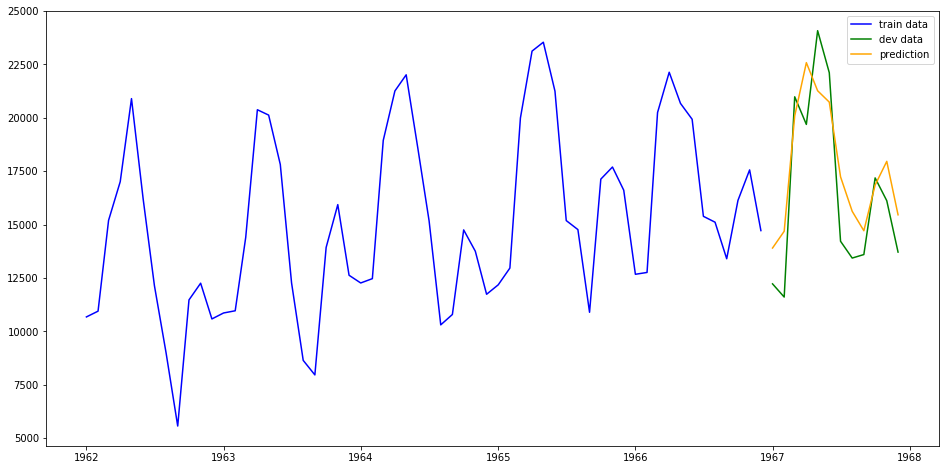

In [123]:
figure = plt.subplots(1,1, figsize=(16,8))
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [124]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

2101.2630602425143

In [125]:
Xy_with_lags.head()

,sales,dt,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
24,10677.0,1962-01-01,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0,9374.0,7237.0
25,10947.0,1962-02-01,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0,9374.0
26,15200.0,1962-03-01,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0,11837.0
27,17010.0,1962-04-01,15200.0,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0,13784.0
28,20900.0,1962-05-01,17010.0,15200.0,10947.0,10677.0,8816.0,12759.0,10015.0,7610.0,7975.0,11143.0,13821.0,15926.0


In [108]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Xy_with_lags.drop(["dt", "sales"], axis=1), Xy_with_lags["sales"])

y_dev_hat = reg.predict(validation.drop(["dt", "sales"], axis=1))

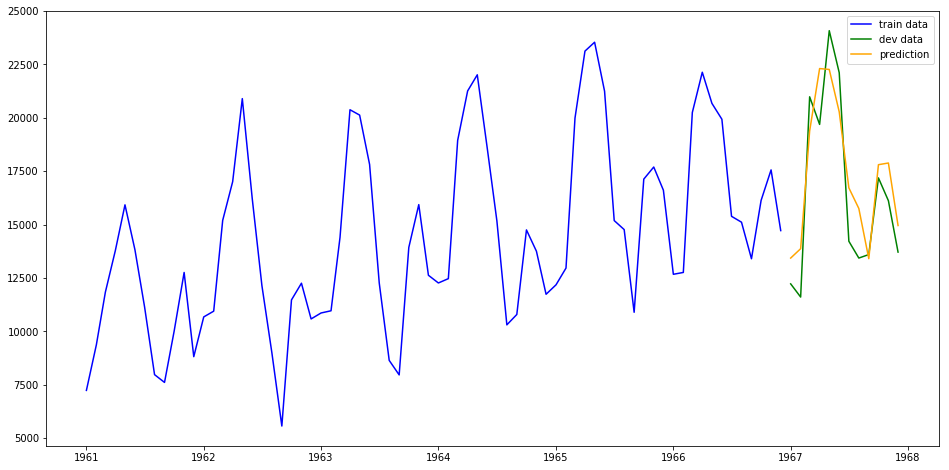

In [109]:
figure = plt.subplots(1,1, figsize=(16,8))
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [110]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1811.4340831555019

Ahora hemos mejorado más que el doble!!!!

##  Modelo 5: modelo recurrente 

A menudo en la práctica nosotros buscamos una predición para todo el año. Vamos a asumir que estamos en Enero de 1967 y nos gustaria tener una previsión par todos los meses de 1967 y así la empresa podría optimizar el stock mensual.

Podemos hacer lo mismo que en el modelo anterior pero usando las prediciones anteriores. Esto significa que para predecir Abril usaremos los ultimos 12 meses últimos, tomando para Enero, Febreo y Marzo los datos de predicion. 

In [112]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

y_dev_hat = recurrent_prediction(y_train, 12, reg)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1778.7318488630733

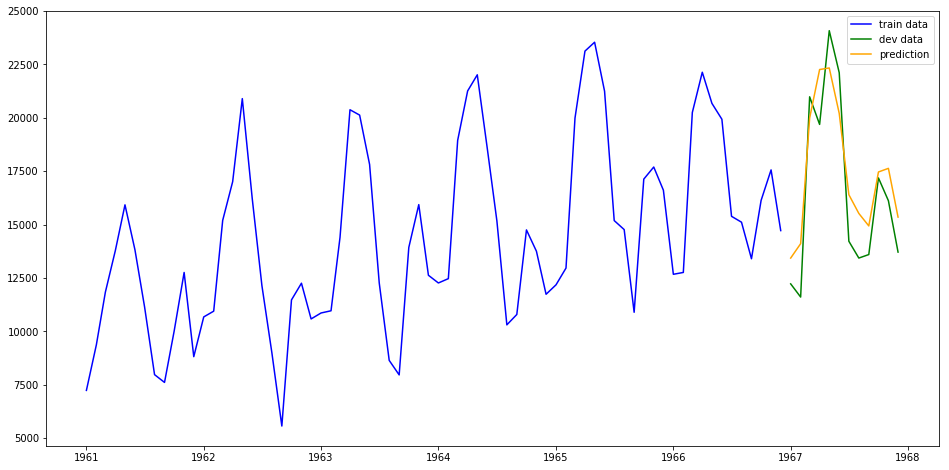

In [114]:
figure = plt.subplots(1,1, figsize=(16,8))
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

##  Modelo 6: K-nearest neighborhood 

In [150]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:]
Xy_with_lags.head()

,sales,dt,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
12,7237.0,1961-01-01,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
13,9374.0,1961-02-01,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
14,11837.0,1961-03-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
15,13784.0,1961-04-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
16,15926.0,1961-05-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [151]:
X_train.shape

(60,)

In [156]:
from sklearn.neighbors import KNeighborsRegressor

N_lags = 12
X_train = Xy_with_lags[Xy_with_lags["dt"].dt.year < 1967]
y_train = Xy_with_lags[Xy_with_lags["dt"].dt.year < 1967]["sales"]
X_dev = Xy_with_lags[Xy_with_lags["dt"].dt.year == 1967]
y_dev = Xy_with_lags[Xy_with_lags["dt"].dt.year == 1967]["sales"]

for i in range(1,10):
    reg_kn = KNeighborsRegressor(n_neighbors=i)
    reg_kn.fit(X_train.drop(["dt", "sales"], axis=1), y_train)
    y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
    print("Neighbors: ", i, "RSME: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

Neighbors:  1 RSME:  1653.4736919588408
Neighbors:  2 RSME:  1557.7931973896066
Neighbors:  3 RSME:  1866.014777044423
Neighbors:  4 RSME:  1659.9309144133078
Neighbors:  5 RSME:  1664.4863111482778
Neighbors:  6 RSME:  1902.0093699870456
Neighbors:  7 RSME:  1985.8576811020062
Neighbors:  8 RSME:  1838.954596806181
Neighbors:  9 RSME:  1959.1967547615814


In [157]:
reg_kn = KNeighborsRegressor(n_neighbors=2)
reg_kn.fit(X_train.drop(["dt", "sales"], axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)

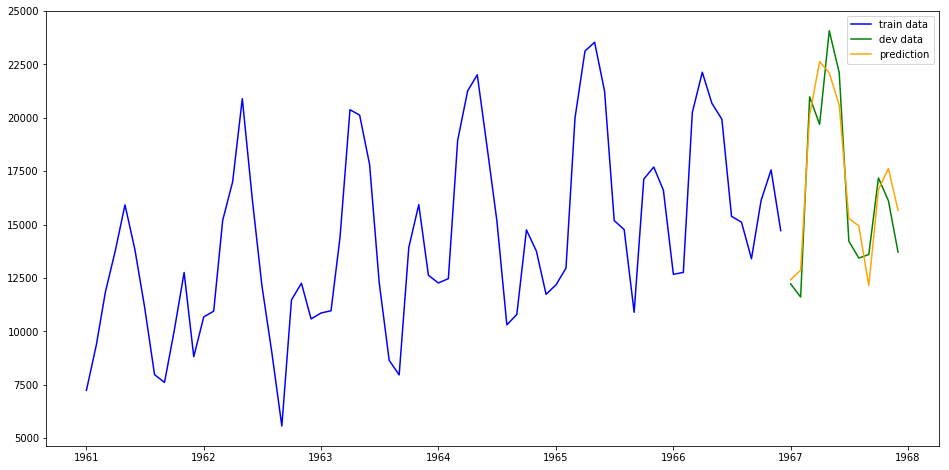

In [159]:
figure = plt.subplots(1,1,figsize=(16,8))
plot_predicition(X_train["dt"], y_train, X_dev["dt"], y_dev, y_dev_hat)

 Elige tu mejor modelo para el parámetro
 n_neighbors

In [ ]:
#WRITE YOUR CODE

##  Modelo 7: Random Forest

In [189]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pruebas = pd.DataFrame(columns=["N_estimators", "Max_depth", "RSME"])

for i in range(1,20):
    for j in range(1,20):
        reg_rf = RandomForestRegressor(n_estimators=i,
                                       max_depth=j
                                       , random_state=667)
        reg_rf.fit(X_train.drop(["dt","sales"], axis=1), y_train)
        y_dev_hat = recurrent_prediction(y_train, N_lags, reg_rf)
        RSME = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
        temp = pd.DataFrame({"N_estimators": [i], "Max_depth": [j], "RSME": [RSME]})
        pruebas = pruebas.append(temp)

In [190]:
pruebas[pruebas["RSME"] == pruebas["RSME"].min()]

,N_estimators,Max_depth,RSME
0,9,10,1486.835504


Elige tu mejor modelo para los parámetros n_estimators y max_depth

In [ ]:
#WRITE YOUR CODE

In [163]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

reg_rf = RandomForestRegressor(n_estimators=5,
                               max_depth=5
                               , random_state=667)
reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_test, y_test_hat))

NameError: name 'y_test' is not defined

In [ ]:
plot_predicition(X_train_dev, y_train_dev, X_test, y_test, y_test_hat)

## Modelo 8: Autoregression (AR) 

In [191]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1773.1012131861025


/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


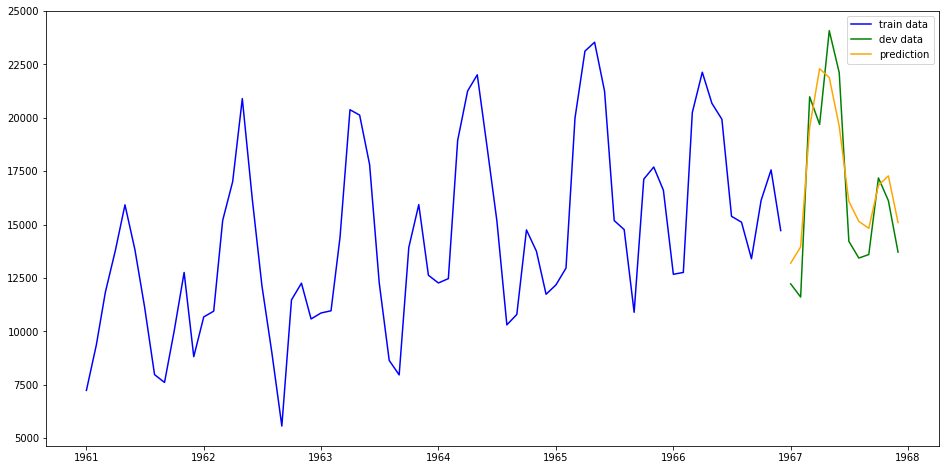

In [194]:
figure = plt.subplots(1,1,figsize=(16,8))
plot_predicition(X_train["dt"], y_train, X_dev["dt"], y_dev, y_dev_hat)

## Modelo 8: Autoregression Moving Average (ARIMA) 

In [195]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [196]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

2188.095000752611


/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


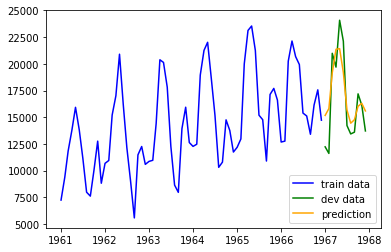

In [198]:
plot_predicition(X_train["dt"], y_train, X_dev["dt"], y_dev, y_dev_hat)

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
